In [39]:
import sys 
sys.path.append('../../')

import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian, value_and_grad
from jax.lax import scan
# from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np
import jax.debug as deb

from jax.flatten_util import ravel_pytree

import numpy as onp
from time_opt_erg_lib.dynamics import DoubleIntegrator, SingleIntegrator2D

from time_opt_erg_lib.ergodic_metric import ErgodicMetric
from time_opt_erg_lib.obstacle import Obstacle
from time_opt_erg_lib.cbf import constr2CBF
from time_opt_erg_lib.fourier_utils import BasisFunc, get_phik, get_ck
from time_opt_erg_lib.target_distribution import TargetDistribution
from time_opt_erg_lib.cbf_utils import sdf2cbf
from IPython.display import clear_output
import matplotlib.pyplot as plt

from time_opt_erg_lib.opt_solver import AugmentedLagrangeSolver
import yaml
import pickle as pkl
import matplotlib

def build_erg_time_opt_solver(args, target_distr):
    
    ## <--- I DO NOT LIKE THIS
    workspace_bnds = args['wrksp_bnds']

    # @vmap
    def emap(x):
        """ Function that maps states to workspace """
        return np.array([
            (x[0]-workspace_bnds[0][0])/(workspace_bnds[0][1]-workspace_bnds[0][0]), 
            (x[1]-workspace_bnds[1][0])/(workspace_bnds[1][1]-workspace_bnds[1][0])])
            
    
    basis           = BasisFunc(n_basis=[16,16], emap=emap)
    erg_metric      = ErgodicMetric(basis)
    robot_model     = SingleIntegrator2D()
    n,m = robot_model.n, robot_model.m

    args.update({
        'phik' : get_phik(target_distr.evals, basis),
    })

    def barrier_cost(e):
        """ Barrier function to avoid robot going out of workspace """
        return (np.maximum(0, e-1) + np.maximum(0, -e))**2

    # @jit
    def loss(params, args):
        x = params['x']
        u = params['u']
        tf = params['tf']
        N = args['N']
        dt = tf/N
        e = vmap(emap)(x)
        """ Traj opt loss function, not the same as erg metric """
        return np.sum(barrier_cost(e)) + tf

    def eq_constr(params, args):
        """ dynamic equality constriants """
        x = params['x']
        u = params['u']

        x0 = args['x0']
        xf = args['xf']
        tf = params['tf']
        N = args['N']
        dt = tf/N
        return np.vstack([
            x[0] - x0, 
            x[1:,:]-(x[:-1,:]+dt*vmap(robot_model.dfdt)(x[:-1,:], u[:-1,:])),
            x[-1] - xf
        ])

    def ineq_constr(params, args):
        """ inequality constraints"""
        x = params['x']
        u = params['u']
        phik = args['phik']
        tf = params['tf']
        N = args['N']
        dt = tf/N
        ck = get_ck(x, basis, tf, dt)
        erg = erg_metric(ck, phik)
        deb.print("erg: {a}", a=erg)
        _erg_ineq = [np.array([2*(erg - args['erg_ub']), -tf])]
        _ctrl_disk = [(u[:,0]**2 + u[:,1]**2 - 1.2345).flatten()]
        return np.concatenate(_erg_ineq + _ctrl_disk)


    x = np.linspace(args['x0'], args['xf'], args['N'], endpoint=True)
    u = np.zeros((args['N'], robot_model.m))
    init_sol = {'x': x, 'u' : u, 'tf': np.array(10.0)}
    solver = AugmentedLagrangeSolver(
                    init_sol,
                    loss, 
                    eq_constr, 
                    ineq_constr, 
                    args, 
                    step_size=1e-3,
                    c=1.0)
    return solver

erg: 0.21684113144874573
erg: 0.21413761377334595
erg: 0.21684113144874573
erg: 0.2119762897491455
erg: 0.21413761377334595
erg: 0.2102365642786026
erg: 0.2119762897491455
erg: 0.20878644287586212
erg: 0.2102365642786026
erg: 0.20756939053535461
erg: 0.20878644287586212
erg: 0.206527441740036
erg: 0.20756939053535461
erg: 0.20562677085399628
erg: 0.206527441740036
erg: 0.20483750104904175
erg: 0.20562677085399628
erg: 0.20413297414779663
erg: 0.20483750104904175
erg: 0.20347380638122559
erg: 0.20413297414779663
erg: 0.2028053104877472
erg: 0.20347380638122559
erg: 0.20207998156547546
erg: 0.2028053104877472
erg: 0.20130248367786407
erg: 0.20207998156547546
erg: 0.20049716532230377
erg: 0.20130248367786407
erg: 0.19966614246368408
erg: 0.20049716532230377
erg: 0.1988009661436081
erg: 0.19966614246368408
erg: 0.19790662825107574
erg: 0.1988009661436081
erg: 0.1969994306564331
erg: 0.19790662825107574
erg: 0.1961008459329605
erg: 0.1969994306564331
erg: 0.19522851705551147
erg: 0.19610084

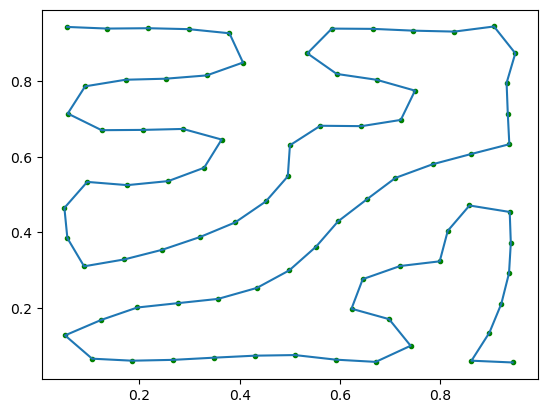

In [37]:
log = {
    'time' : [],
    'erg_ub' : [],
    'sols' : []
}

args = {
    'N' : 81, 
    'x0' : np.array([0.944, 0.055]),
    'xf' : np.array([0.055, 0.944]),
    'erg_ub' : 0.001270128,
    'wrksp_bnds' : np.array([[0.,1.],[0.,1.]])
}

target_distr    = TargetDistribution()

solver = build_erg_time_opt_solver(args, target_distr)

solver.solve(args=args, max_iter=20_000, eps=1e-8, alpha=1.0005)
timeopt_sol = solver.get_solution()
# init_sol = deepcopy(sol)
# log['time'].append(np.array(sol['tf']))
# log['erg_ub'].append(erg_ub)
# log['sols'].append(sol)
# print(sol['tf'], erg_ub)
    # plt.figure(i)
plt.plot(timeopt_sol['x'][:,0], timeopt_sol['x'][:,1],'g.')
plt.plot(timeopt_sol['x'][:,0], timeopt_sol['x'][:,1])


# plt.show()

In [59]:
def build_erg_solver(args, target_distr):
    
    ## <--- I DO NOT LIKE THIS
    workspace_bnds = args['wrksp_bnds']

    # @vmap
    def emap(x):
        """ Function that maps states to workspace """
        return np.array([
            (x[0]-workspace_bnds[0][0])/(workspace_bnds[0][1]-workspace_bnds[0][0]), 
            (x[1]-workspace_bnds[1][0])/(workspace_bnds[1][1]-workspace_bnds[1][0])])
            
    
    basis           = BasisFunc(n_basis=[16,16], emap=emap)
    erg_metric      = ErgodicMetric(basis)
    robot_model     = SingleIntegrator2D()
    n,m = robot_model.n, robot_model.m

    args.update({
        'phik' : get_phik(target_distr.evals, basis),
    })

    def barrier_cost(e):
        """ Barrier function to avoid robot going out of workspace """
        return (np.maximum(0, e-1) + np.maximum(0, -e))**2

    # @jit
    def loss(params, args):
        x = params['x']
        u = params['u']
        tf = args['tf']
        phik = args['phik']
        N = args['N']
        dt = tf/N
        e = vmap(emap)(x)
        ck = get_ck(x, basis, tf, dt)
        erg = erg_metric(ck, phik)
        deb.print("erg: {a}", a=erg)
        """ Traj opt loss function, not the same as erg metric """
        return np.sum(barrier_cost(e)) + erg

    def eq_constr(params, args):
        """ dynamic equality constriants """
        x = params['x']
        u = params['u']

        x0 = args['x0']
        xf = args['xf']
        tf = args['tf']
        N = args['N']
        dt = tf/N
        return np.vstack([
            x[0] - x0, 
            x[1:,:]-(x[:-1,:]+dt*vmap(robot_model.dfdt)(x[:-1,:], u[:-1,:])),
            x[-1] - xf
        ])

    def ineq_constr(params, args):
        """ inequality constraints"""
        x = params['x']
        u = params['u']
        tf = args['tf']
        N = args['N']
        dt = tf/N
        # ck = get_ck(x, basis, tf, dt)
        # erg = erg_metric(ck, phik)
        # deb.print("erg: {a}", a=erg)
        # _erg_ineq = [np.array([2*(erg - args['erg_ub']), -tf])]
        _ctrl_disk = [(u[:,0]**2 + u[:,1]**2 - 1.2345).flatten()]
        return np.concatenate(_ctrl_disk)


    x = np.linspace(args['x0'], args['xf'], args['N'], endpoint=True)
    u = np.zeros((args['N'], robot_model.m))
    init_sol = {'x': x, 'u' : u}
    solver = AugmentedLagrangeSolver(
                    init_sol,
                    loss, 
                    eq_constr, 
                    ineq_constr, 
                    args, 
                    step_size=1e-3,
                    c=1.0)
    return solver

erg: 0.21684113144874573
erg: 0.214136004447937
erg: 0.21242600679397583
erg: 0.21113820374011993
erg: 0.21007709205150604
erg: 0.20918503403663635
erg: 0.20841193199157715
erg: 0.20772498846054077
erg: 0.20711207389831543
erg: 0.20656518638134003
erg: 0.20606783032417297
erg: 0.20562425255775452
erg: 0.20521663129329681
erg: 0.20484957098960876
erg: 0.2045191079378128
erg: 0.20421653985977173
erg: 0.2039472758769989
erg: 0.2037021666765213
erg: 0.20348569750785828
erg: 0.20329126715660095
erg: 0.20312052965164185
erg: 0.20296965539455414
erg: 0.2028386890888214
erg: 0.20272532105445862
erg: 0.2026304453611374
erg: 0.20254898071289062
erg: 0.20248466730117798
erg: 0.20243220031261444
erg: 0.20239658653736115
erg: 0.20237231254577637
erg: 0.20236337184906006
erg: 0.20236554741859436
erg: 0.20238250494003296
erg: 0.2024124562740326
erg: 0.20245566964149475
erg: 0.20251111686229706
erg: 0.20258226990699768
erg: 0.20266209542751312
erg: 0.2027541995048523
erg: 0.20285378396511078
erg: 0.20

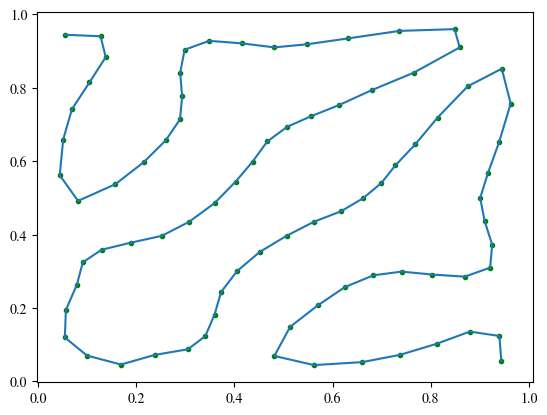

In [60]:
log = {
    'time' : [],
    'erg_ub' : [],
    'sols' : []
}

args = {
    'N' : 81, 
    'tf' : np.array(10.0),
    'x0' : np.array([0.944, 0.055]),
    'xf' : np.array([0.055, 0.944]),
    'erg_ub' : 0.001270128,
    'wrksp_bnds' : np.array([[0.,1.],[0.,1.]])
}

target_distr    = TargetDistribution()

solver = build_erg_solver(args, target_distr)

solver.solve(args=args, max_iter=20_000, eps=1e-8, alpha=1.0005)
benchmark_sol = solver.get_solution()
# init_sol = deepcopy(sol)
# log['time'].append(np.array(sol['tf']))
# log['erg_ub'].append(erg_ub)
# log['sols'].append(sol)
# print(sol['tf'], erg_ub)
    # plt.figure(i)
plt.plot(benchmark_sol['x'][:,0], benchmark_sol['x'][:,1],'g.')
plt.plot(benchmark_sol['x'][:,0], benchmark_sol['x'][:,1])

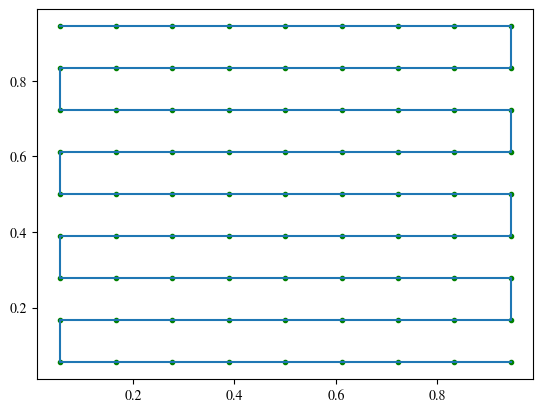

In [41]:
with open("lawn_mower.pkl", "rb") as handle:
  lawn = pkl.load(handle)
xs = a[0][:,0]
ys = a[0][:,1]
plt.plot(xs, ys,'g.')
plt.plot(xs, ys)

In [61]:
timeopt_sol['tf']

Array(5.923689, dtype=float32, weak_type=True)

In [51]:
workspace_bnds = args['wrksp_bnds']

# @vmap
def emap(x):
    """ Function that maps states to workspace """
    return np.array([
        (x[0]-workspace_bnds[0][0])/(workspace_bnds[0][1]-workspace_bnds[0][0]), 
        (x[1]-workspace_bnds[1][0])/(workspace_bnds[1][1]-workspace_bnds[1][0])])
        

basis           = BasisFunc(n_basis=[16,16], emap=emap)
erg_metric      = ErgodicMetric(basis)
args = {
    'N' : 81, 
    'tf' : np.array(10.0),
    'x0' : np.array([0.944, 0.055]),
    'xf' : np.array([0.055, 0.944]),
    'erg_ub' : 0.001270128,
    'wrksp_bnds' : np.array([[0.,1.],[0.,1.]])
}

target_distr    = TargetDistribution()
def get_metric_vals(params, args):
    x = params['x']
    u = params['u']
    tf = args['tf']
    phik = args['phik']
    N = args['N']
    dt = tf/N
    e = vmap(emap)(x)
    ck = get_ck(x, basis, tf, dt)
    erg = erg_metric(ck, phik)

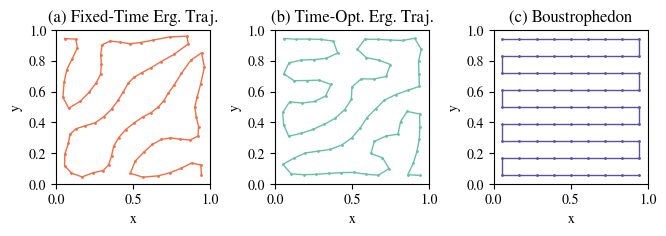

In [58]:
plt.rcParams["font.family"] = "freeserif"

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8.0, 2))
cmap = matplotlib.cm.get_cmap('Spectral')
rgba = cmap(1.0)

ax[2].plot(lawn[0][:,0], lawn[0][:,1], linewidth='1', color=rgba)
ax[2].scatter(lawn[0][:,0], lawn[0][:,1], s=1,color=rgba)

ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('(c) Boustrophedon')
ax[2].set_xlim(0,1)
ax[2].set_ylim(0,1)
ax[2].set_aspect('equal', adjustable='box')

rgba = cmap(0.8)

ax[1].plot(timeopt_sol['x'][:,0], timeopt_sol['x'][:,1], linewidth='1', color=rgba)
ax[1].scatter(timeopt_sol['x'][:,0], timeopt_sol['x'][:,1], s=1,color=rgba)

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('(b) Time-Opt. Erg. Traj.')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)
ax[1].set_aspect('equal', adjustable='box')


rgba = cmap(0.2)
ax[0].plot(benchmark_sol['x'][:,0], benchmark_sol['x'][:,1], linewidth='1', color=rgba)
ax[0].scatter(benchmark_sol['x'][:,0], benchmark_sol['x'][:,1], s=1,color=rgba)
ax[0].set_aspect('equal', adjustable='box')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
ax[0].set_title('(a) Fixed-Time Erg. Traj.')
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm,
#                                 orientation='horizontal')
# cb1.set_label('Some Units')
# plt.tight_layout()
plt.savefig('boustrophedon_comparisons.svg')

In [6]:
for erg_ub, sol in zip(erg_ubs, log['sols']):
    print(sol['tf'], np.max(np.linalg.norm(sol['u'],axis=1)))
    

5.007921 1.4129729
5.015943 1.413621
5.73927 1.3969742
6.969608 1.4142135
8.449434 1.413471
10.482965 1.4149771


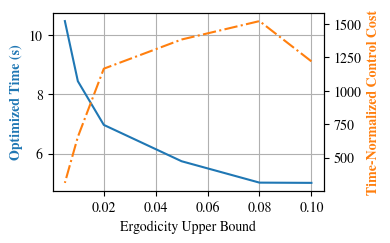

In [30]:
plt.rcParams["font.family"] = "freeserif"

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax1 = plt.subplots(figsize=(4,2.5))


ax1.plot(log['erg_ub'], log['time'], color=colors[0])
# plt.plot(log['time'], ctrl_sat)
ax1.set_xlabel('Ergodicity Upper Bound', fontname='freeserif')
ax1.set_ylabel('Optimized Time (s)', color=colors[0], fontname='freeserif', weight='bold')
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(log['erg_ub'], ctrl_sat, color=colors[1], linestyle='-.')
ax2.set_ylabel('Time-Normalized Control Cost', color=colors[1], fontname='freeserif', weight='bold')
plt.tight_layout()
plt.savefig('opt-results.svg')
# plt.show()

### Control Knot Point dependency

unsuccessful, tol:  0.0013332367
5.058998 50
done in  6010  iterations
4.9309573 100
done in  4728  iterations
5.557756 200
unsuccessful, tol:  0.027668
5.3259907 300
done in  3935  iterations
6.242244 400
unsuccessful, tol:  0.046283722
5.4803443 500
done in  6193  iterations
5.556984 600


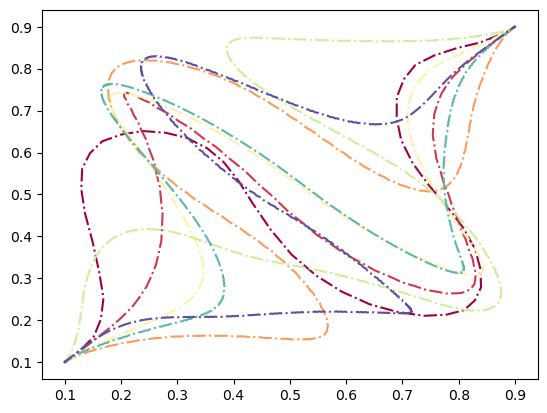

In [41]:
N_list = [50, 100, 200, 300, 400, 500, 600]


log = {
    'time' : [],
    'erg_ub' : [],
    'sols' : []
}

args = {
    'N' : 200, 
    'x0' : np.array([0.1, 0.1, 0., 0.]),
    'xf' : np.array([0.9, 0.9, 0., 0.]),
    'erg_ub' : 0.05,
    # 'alpha' : 0.8,
}

x = np.linspace(args['x0'], args['xf'], args['N'], endpoint=True)
u = np.zeros((args['N'], 2))
init_sol = {'x': x, 'u' : u, 'tf': np.array(6.0)}

cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=N_list[0], vmax=N_list[-1])

for i, N in enumerate(N_list):
    args.update({
        'N' : N,
        # 'alpha' : 0.8,
    })
    
    x = np.linspace(args['x0'], args['xf'], args['N'], endpoint=True)
    u = np.zeros((args['N'], 2))
    init_sol = {'x': x, 'u' : u, 'tf': np.array(10.0)}

    solver = build_erg_time_opt_solver(init_sol, args)

    # solver.reset()
    # solver = build_erg_time_opt_solver(init_sol, args)
    solver.solve(args=args, max_iter=10000, eps=1e-7)
    sol = solver.get_solution()
    init_sol = deepcopy(sol)
    log['time'].append(np.array(sol['tf']))
    # log['erg_ub'].append(erg_ub)
    log['sols'].append(sol)
    print(sol['tf'], N)
    # plt.figure(i)
    rgba = cmap(norm(N))

    # plt.scatter(sol['x'][:,0], sol['x'][:,1],  color=rgba)
    plt.plot(sol['x'][:,0], sol['x'][:,1], '-.', color=rgba)
    
# plt.colorbar()
# plt.show()

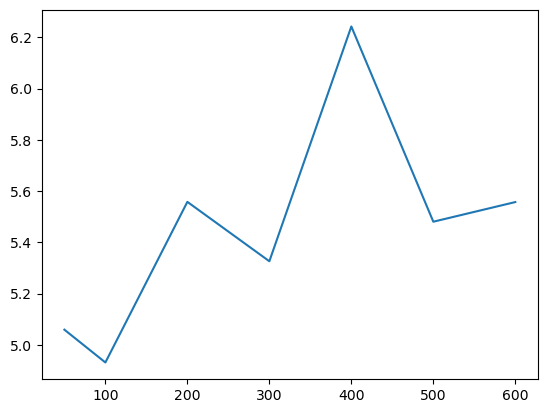

In [42]:
tf_sols = [_sol['tf'] for _sol in log['sols']]
plt.plot(N_list, tf_sols)

In [43]:
np.mean(tf_sols), np.std(tf_sols)

(5.4504676, 0.39447838)

### Need to find table for initial condition dependency

unsuccessful, tol:  0.014213562
5.2344503 4.0
unsuccessful, tol:  0.01622963
5.1097794 5.0
done in  4157  iterations
4.9140577 6.0
unsuccessful, tol:  0.014886856
4.632121 7.0


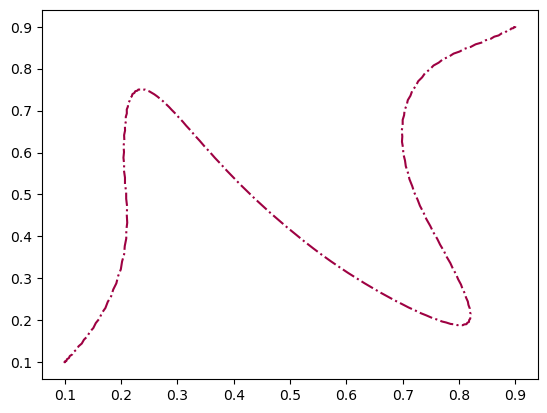

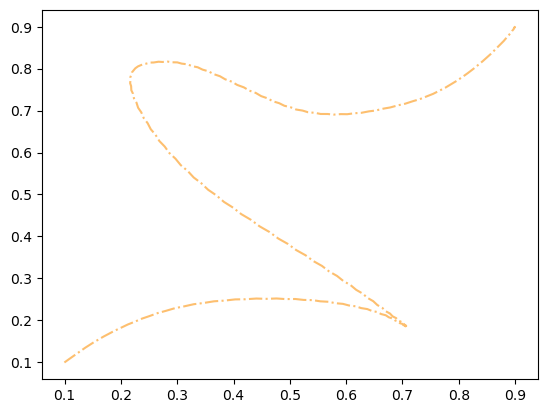

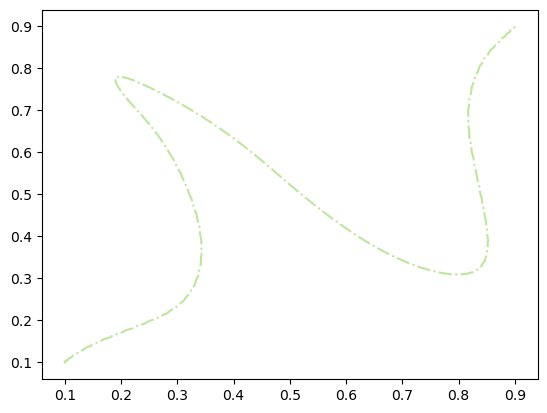

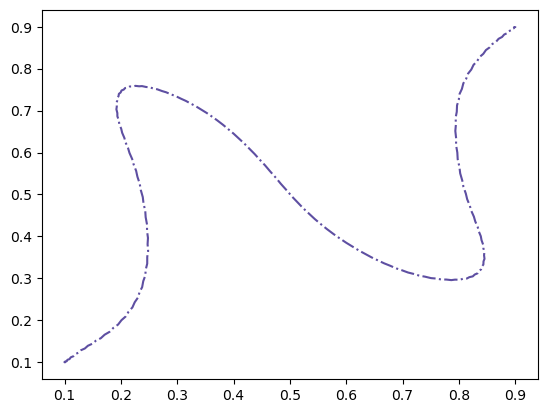

In [35]:
tf_list = np.arange(4, 8, step=1.0)


log = {
    'time' : [],
    'erg_ub' : [],
    'sols' : []
}

args = {
    'N' : 200, 
    'x0' : np.array([0.1, 0.1, 0., 0.]),
    'xf' : np.array([0.9, 0.9, 0., 0.]),
    'erg_ub' : 0.05,
    # 'alpha' : 0.8,
}

x = np.linspace(args['x0'], args['xf'], args['N'], endpoint=True)
u = np.zeros((args['N'], 2))
init_sol = {'x': x, 'u' : u, 'tf': np.array(10.0)}

cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=tf_list[0], vmax=tf_list[-1])

for i, init_tf in enumerate(tf_list):


    init_sol = {'x': x, 'u' : u, 'tf': np.array(init_tf)}

    solver = build_erg_time_opt_solver(init_sol, args, step_size=1e-3, c=1.0)

    # solver.reset()
    # solver = build_erg_time_opt_solver(init_sol, args)
    solver.solve(args=args, max_iter=10000, eps=1e-8, alpha=1.001)
    sol = solver.get_solution()
    init_sol = deepcopy(sol)
    log['time'].append(np.array(sol['tf']))
    # log['erg_ub'].append(erg_ub)
    log['sols'].append(sol)
    print(sol['tf'], init_tf)
    # plt.figure(i)
    rgba = cmap(norm(init_tf))
    plt.figure(i)
    # plt.scatter(sol['x'][:,0], sol['x'][:,1],  color=rgba)
    plt.plot(sol['x'][:,0], sol['x'][:,1], '-.', color=rgba)
    
# plt.colorbar()
# plt.show()

In [37]:
opt_tf = []
for init_tf, _sol in zip(tf_list, log['sols']):
    opt_tf.append(_sol['tf'])


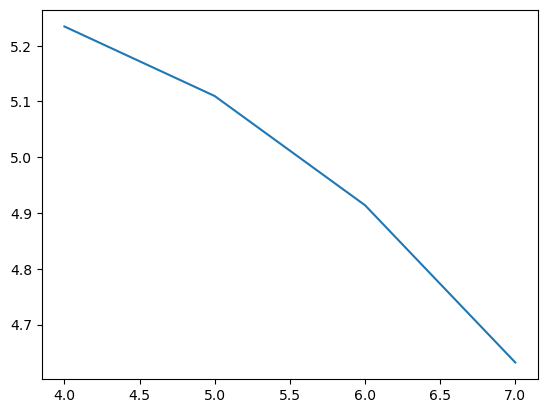

In [38]:
plt.plot(tf_list, np.stack(opt_tf))

In [39]:
np.mean(opt_tf)

4.972602

In [40]:
np.std(opt_tf)

0.22734162